# Application 2: Framingham Heart Study

This notebook contains an application illustration for the following paper:

Brachem, J., Wiemann, P. F. V., & Kneib, T. (2024). Bayesian penalized transformation models: Structured additive location-scale regression for arbitrary conditional distributions (No. arXiv:2404.07440). arXiv. https://doi.org/10.48550/arXiv.2404.07440

The application is the Framingham Heart Study (Zhang & Davidian, 2001). 
The data comprises a total of 1 044 cholesterol level measurements taken of 200
study participants over the course of up to ten years

The dataset was obtained from the R package `qrLMM` (Galarza, 2024). We quote the description of the dataset here:

This data frame contains the following columns:
- `newid` a numeric vector indicating the subject on which the measurement was made. It represents the subject number in the sample.
- `ID` a numeric vector indicating the subject on which the measurement was made. It represents the subject number in the population.
- `cholst` cholesterol level for patient newid.
- `sex` a dichotomous gender (0=female, 1=male).
- `age` of the patient in years.
- `years` elapsed since the start of the study to the current measurement.


References:

- Zhang, D., & Davidian, M. (2001). Linear mixed models with flexible distributions of random effects for longitudinal data. Biometrics, 57(3), 795–802. https://doi.org/10.1111/j.0006-341X.2001.00795.x
- Galarza CE, Lachos VH (2024). qrLMM: Quantile Regression for Linear
  Mixed-Effects Models. R package version 2.3. https://cran.r-project.org/web/packages/qrLMM/qrLMM.pdf

## Setup

We need to verify that the correct environment is being used. You can check with this command. The file path should point to the Python executable in your virtual environment.

In [1]:
import sys

print(sys.executable)

/Users/johannesbrachem/Documents/git/ptm-supplement/.venv/bin/python


### Load packages

In [2]:
from pathlib import Path  # for filepath operations
import pandas as pd  # dataframe library
import plotnine as p9  # plotting like with ggplot2
import jax  # a core dependency of liesel and liesel_ptm; provides autodiff and just-in-time-compilation
import jax.numpy as jnp  # jax-compatible numerical operations

import liesel.goose as gs  # liesel's MCMC library, imported here for its diagnostic functions

import liesel_ptm as ptm  # PTM functionality
from liesel_ptm import (
    ps,
    lin,
    ri,
    term,
    term_ri,
)  # some specific functions for PTM model setup

In [3]:
jax.config.update("jax_enable_x64", True)  # enable double precision floats in JAX

In [4]:
# File path handling
wd = Path.cwd()
print(wd)  # print current working directory
if wd.name == "demos":
    demos_dir = wd
    data_dir = wd / ".." / "data"
else:
    demos_dir = wd / "demos"
    data_dir = wd / "data"
print(demos_dir.resolve())  # print demos directory
print(data_dir.resolve())  # print data directory

/Users/johannesbrachem/Documents/git/ptm-supplement/demos
/Users/johannesbrachem/Documents/git/ptm-supplement/demos
/Users/johannesbrachem/Documents/git/ptm-supplement/data


### Load data

In [5]:
data = pd.read_csv(data_dir / "framingham.csv")
data.head()

,newid,ID,cholst,sex,age,year,fold
0,1,1244,175,1,32,0,9
1,1,1244,198,1,32,2,9
2,1,1244,205,1,32,4,9
3,1,1244,228,1,32,6,9
4,1,1244,214,1,32,8,9


### Pre-process data

In [6]:
# standardize cholst variable
cholst_mean = data["cholst"].mean()
cholst_sd = data["cholst"].std()
data["cholst"] = (data["cholst"] - cholst_mean) / cholst_sd

# create age variable
data["age_at_start"] = data["age"]
data["age"] = data["age_at_start"] + data["year"]

# standardize age variable
age_mean = data["age"].mean()
age_sd = data["age"].std()
data["age"] = (data["age"] - age_mean) / age_sd

# recode sex variable
data["sex"] = data["sex"] - 0.5

In [7]:
# split data into train and test datasets
fold = 1
train = data[data["fold"] != fold]
test = data[data["fold"] == fold]

## Model

### Initialize transformation model

In [8]:
model = ptm.LocScalePTM.new_ptm(
    # response can be supplied as an array or as a pandas.Series
    response=train["cholst"],
    # The number of transformation function parameters, J-1 in the paper
    # Higher numbers here increase the flexibility of the transformation function
    # default: 20
    nparam=40,
    a=-7.0,  # Left boundary knot, 'a' in the paper (default: -4.0)
    b=7.0,  # Right boundary knot, 'b' in the paper (default: 4.0)
    # Scale 'phi' of the Weibull(0.5, phi) prior for tau^2_\delta
    # default: 0.5
    tau2_scale=0.5,
    # Controls the width of the transition to extrapolation
    # trafo_lambda=0.1 means the width of the transition segment is 0.1*(b-a)
    trafo_lambda=0.1,
    # A switch that can be used to turn on simple linear extrapolation instead
    # of transition to unit slope
    # for linear extrapolation, use "continue_linearly"
    trafo_target_slope="identity",
    # turn off conversion of all float to float32
    to_float32=False,
)

### Add covariate effects

In [9]:
# initialize effect bases
ps_age = ps(train["age"], nbases=20, xname="age")  # P-Spline basis
lin_sex = lin(train["sex"], xname="sex")  # Linear basis
ri_id = ri(train["newid"], xname="id")  # Random intercept basis

In [10]:
# effects can be added to the "loc" and "scale" predictors using the "+=" operator
model.loc += (
    term.f_ig(
        ps_age, fname="s"
    ),  # P-spline with default inverse gamma prior on the variance parameter
    term.f(lin_sex, fname="s"),  # Linear effect with default flat prior
)

# Random intercept with default inverse gamma prior on the variance parameter
# Can be included by uncommenting this line
# Note that the model needs more warmup and posterior samples to converge in this case

# model.loc += term_ri.f_ig(ri_id, fname="ri")

model.scale += (term.f_ig(ps_age, fname="g"), term.f(lin_sex, fname="g"))

### Build model

In [11]:
# builds the model graph, freezes the model
# No changes to the model structure are possible after this call
model.build()

### Plot model graph

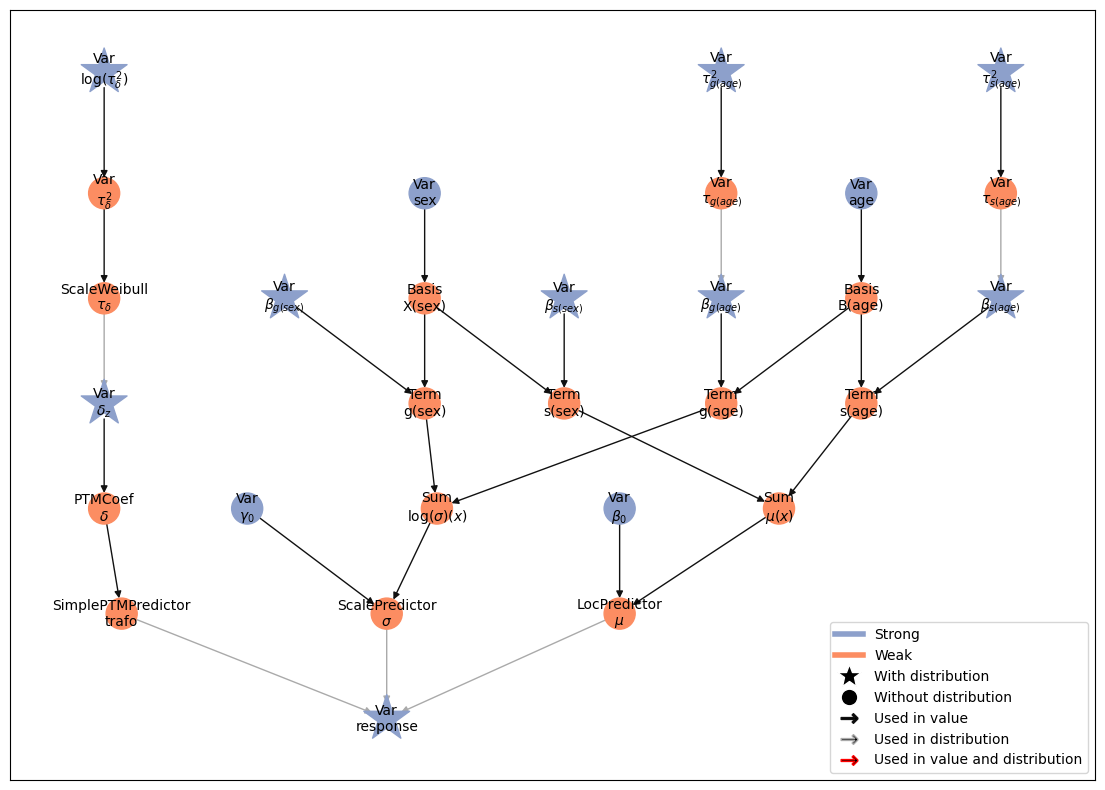

In [12]:
model.graph.plot_vars()

## Run MCMC

We supply relatively low numbers of warmup and posterior samples, and no thinning, here to enable a quick first glance.

In [13]:
results = model.run_mcmc(
    seed=1,
    warmup=500,  # increase if necessary
    posterior=500,  # increase if necessary
    thinning_posterior=1,  # increase if necessary
    num_chains=4,
    warm_start=True,  # whether to apply gradient ascent to find approximations to the posterior modes as initial values
    strategy="iwls-nuts",  # default sampling strategy
    # results can be cached
    # cache_path=demos_dir / "framingham.pickle",
)

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 125 transitions, 25 jitted together
100%|██████████████████████████████████████████| 5/5 [00:15<00:00,  3.18s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 17, 19, 21, 15 / 125 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 445.07chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 17, 10, 7, 4 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 230.30chunk/s]

In [14]:
samples = results.get_posterior_samples()
summary = gs.Summary(results)
errors = summary.error_df().reset_index()

In [15]:
gs.Summary(
    results,
    selected=[
        "$\\beta_{s(sex)}$",
        "$\\beta_{g(sex)}$",
        "$\\tau^2_{ri(id)}$",
        "$\\tau^2_{s(age)}$",
        "$\\tau^2_{g(age)}$",
        "$\\log(\\tau^2_\\delta)$",
    ],
)

Parameter summary:

                                kernel      mean        sd    q_0.05  \
parameter             index                                            
$\beta_{g(sex)}$      (0,)   kernel_01  0.038692  0.051825 -0.042865   
$\beta_{s(sex)}$      (0,)   kernel_05 -0.060036  0.058224 -0.148091   
$\log(\tau^2_\delta)$ ()     kernel_00 -4.230687  0.655131 -5.279194   
$\tau^2_{g(age)}$     ()     kernel_03  0.001798  0.000986  0.000738   
$\tau^2_{s(age)}$     ()     kernel_07  0.002631  0.001730  0.000945   

                                q_0.5    q_0.95  sample_size    ess_bulk  \
parameter             index                                                
$\beta_{g(sex)}$      (0,)   0.036107  0.123586         2000  338.981291   
$\beta_{s(sex)}$      (0,)  -0.066117  0.038893         2000  394.816597   
$\log(\tau^2_\delta)$ ()    -4.249396 -3.097594         2000  190.254527   
$\tau^2_{g(age)}$     ()     0.001554  0.003758         2000  284.532048   
$\tau^2_{s(age)}$     ()     0.002171  0.005880         2000  156.735894   

                               ess_tail      rhat  
parameter             index                        
$\beta_{g(sex)}$      (0,)   356.317035  1.012591  
$\beta_{s(sex)}$      (0,)   533.176268  1.010451  
$\log(\tau^2_\delta)$ ()     318.005236  1.017041  
$\tau^2_{g(age)}$     ()     657.437409  1.019752  
$\tau^2_{s(age)}$     ()     320.856684  1.018015  

Error summary:

                                                    count relative
kernel    error_code error_msg            phase                   
kernel_00 1          divergent transition warmup       50    0.025
                                          posterior     0      0.0
          2          maximum tree depth   warmup      151   0.0755
                                          posterior     0      0.0

## Inspect diagnostics

### General, aggregate diagnostics

In [16]:
diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail", "kernel"]]
    .groupby("variable", as_index=False)
    .agg(
        kernel=("kernel", "unique"),
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,kernel,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,$\beta_0$,[kernel_08],253.493275,253.493275,476.057593,476.057593,1.009150,1.009150
1,$\beta_{g(age)}$,[kernel_02],229.194312,351.571803,299.335112,513.380289,1.016407,1.011187
2,$\beta_{g(sex)}$,[kernel_01],338.981291,338.981291,356.317035,356.317035,1.012591,1.012591
3,$\beta_{s(age)}$,[kernel_06],180.084105,368.214334,396.815649,461.147613,1.034040,1.011501
4,$\beta_{s(sex)}$,[kernel_05],394.816597,394.816597,533.176268,533.176268,1.010451,1.010451
5,$\delta_z$,[kernel_00],1059.507250,2106.975919,590.691534,1198.962724,1.008013,1.003149
6,$\gamma_0$,[kernel_04],280.897646,280.897646,567.289613,567.289613,1.017529,1.017529
7,$\log(\tau^2_\delta)$,[kernel_00],190.254527,190.254527,318.005236,318.005236,1.017041,1.017041
8,$\tau^2_{g(age)}$,[kernel_03],284.532048,284.532048,657.437409,657.437409,1.019752,1.019752
9,$\tau^2_{s(age)}$,[kernel_07],156.735894,156.735894,320.856684,320.856684,1.018015,1.018015


In [17]:
errors

,kernel,error_code,error_msg,phase,count,relative
0,kernel_00,1,divergent transition,warmup,50,0.025
1,kernel_00,1,divergent transition,posterior,0,0.0
2,kernel_00,2,maximum tree depth,warmup,151,0.0755
3,kernel_00,2,maximum tree depth,posterior,0,0.0


### Transformation function diagnostics

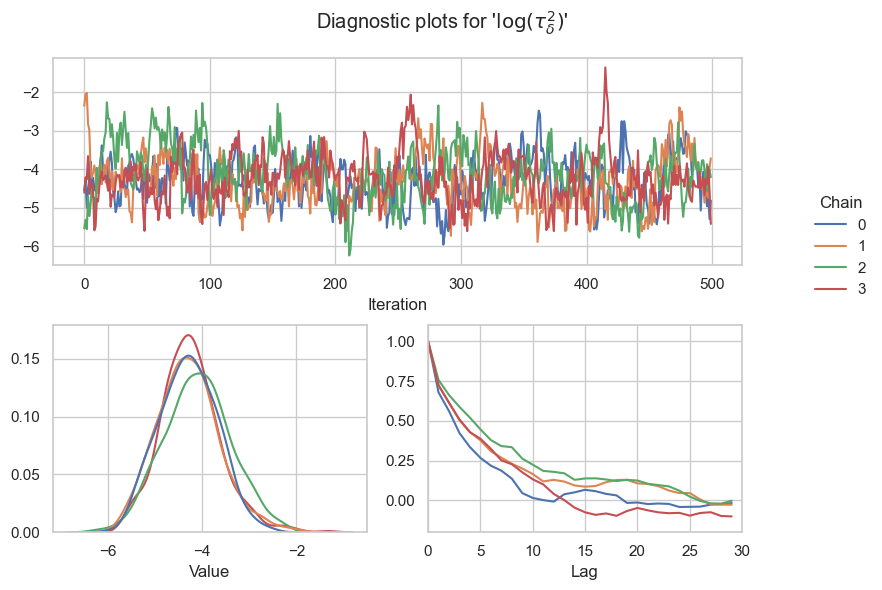

In [18]:
gs.plot_param(results, "$\\log(\\tau^2_\\delta)$")

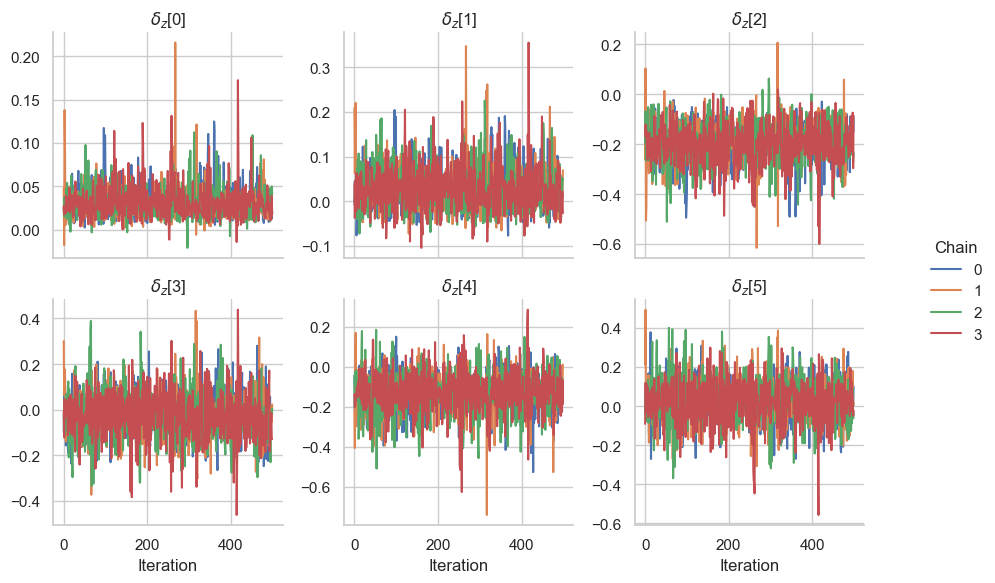

In [19]:
gs.plot_trace(results, "$\\delta_z$", range(6))

## Plot summaries

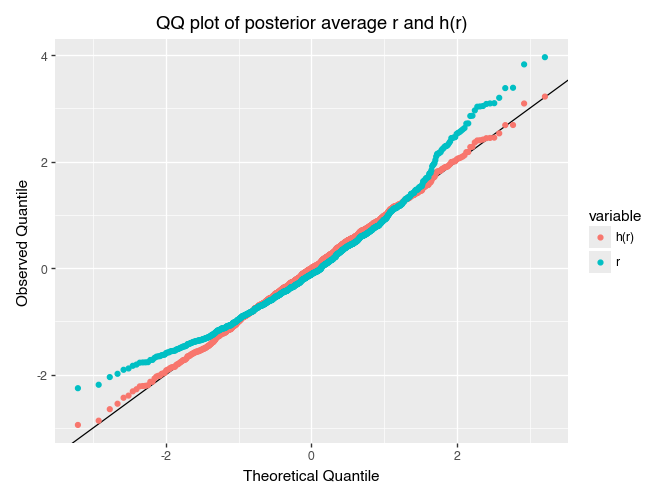

In [20]:
model.plot_qq(samples)

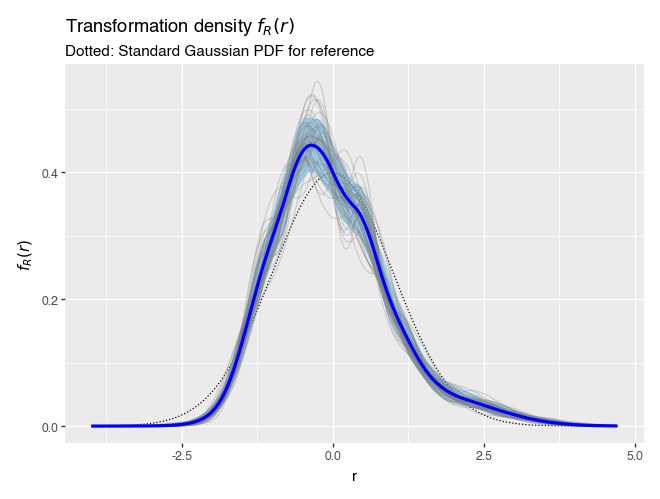

In [21]:
model.plot_r_density(samples)

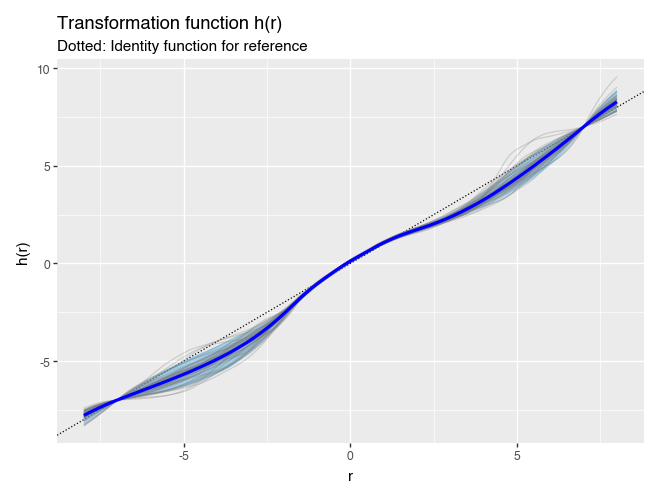

In [31]:
model.plot_trafo(samples, grid=jnp.linspace(-8.0, 8.0, 200))

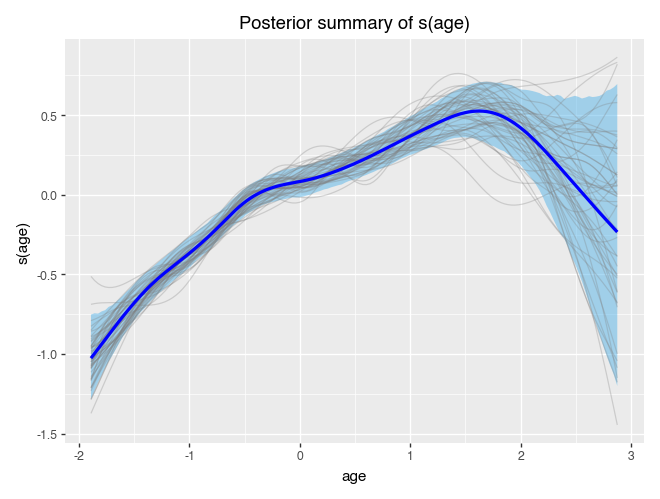

In [ ]:
# note that the model here is fitted on a particular train/test split,
# while the plot in README.md was created using a fit based on the full dataset.
ptm.plot_term(model.loc.terms["s(age)"], samples)

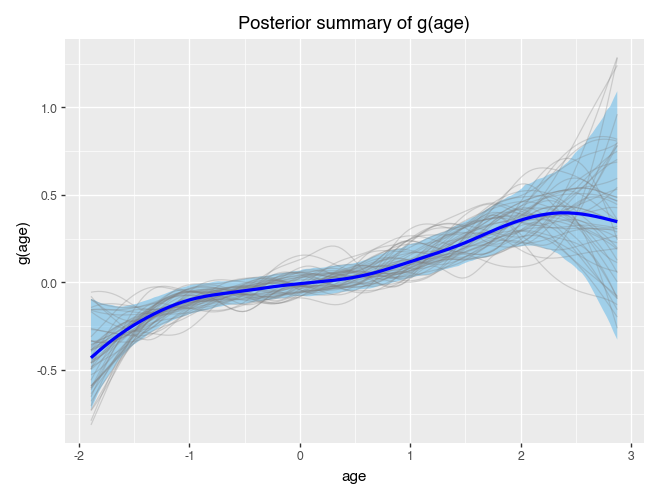

In [24]:
ptm.plot_term(model.scale.terms["g(age)"], samples)

## Predictive samples

In [ ]:
# create new data grid
age_grid = jnp.linspace(data["age"].min(), data["age"].max(), 100)
age_grid = jnp.r_[age_grid, age_grid]
newdata_grid = {"age": age_grid}
newdata_grid["sex"] = jnp.full_like(age_grid, fill_value=-0.5)
newdata_grid["sex"] = newdata_grid["sex"].at[100:].set(0.5)

# for the random intercept, choosing an id that is not present in the training data
# results in drawing samples for an unknown cluster.
# uncomment this line if a random intercept is included

# newdata_grid["id"] = jnp.full_like(age_grid, fill_value=-1)

# initialize a tensorflow distribution instance from the samples and the newdata
dist = model.init_dist(samples, newdata=newdata_grid)

# draw predictive samples
n_pred_samples = 2  # this means: 2 samples for *each* posterior sample
pred_samples = dist.sample((n_pred_samples,), seed=jax.random.key(2))

### Plot predictive conditional quantiles

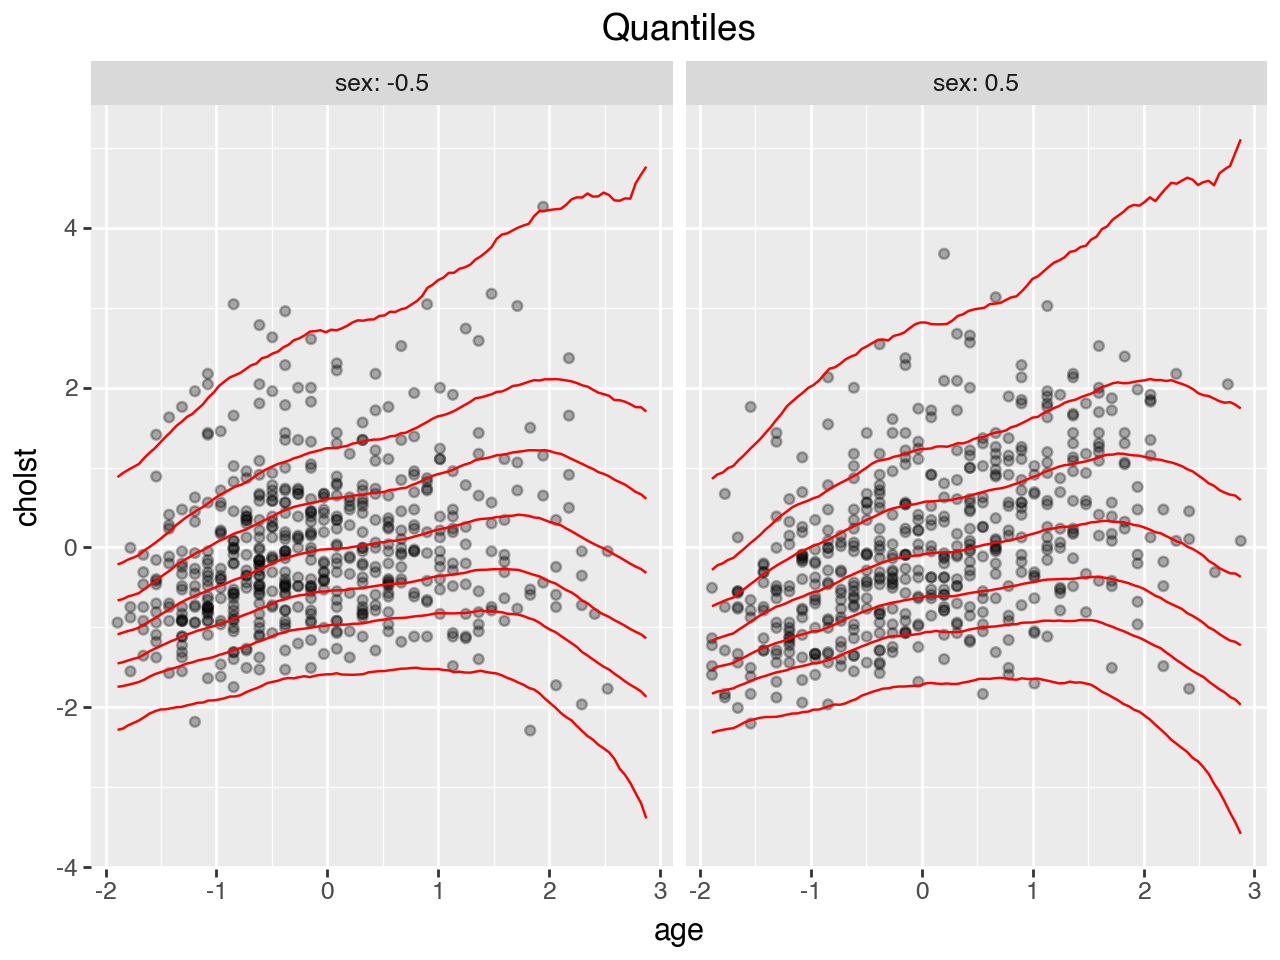

In [33]:
# compute predictive quantiles
probs = jnp.array([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
pred_quantiles = jnp.quantile(pred_samples, q=probs, axis=(0, 1, 2))


# process quantiles to bring them into a nice format for plotting
quantiles = pd.DataFrame(
    pred_quantiles.T, columns=pd.Index([str(p) for p in probs.squeeze()])
)
quantiles["age_std"] = age_grid
quantiles["sex"] = newdata_grid["sex"]
quantiles["sex"] = pd.Categorical(quantiles["sex"])
quantiles = quantiles.reset_index(names="n")

quantiles = quantiles.melt(
    id_vars=["n", "age_std", "sex"], value_name="cholst_quantile", var_name="prob_level"
)

quantiles_sorted = quantiles.sort_values(["sex", "prob_level", "age_std"])

# take a rolling average to smooth the quantiles a little
quantiles_sorted["cholst_rollmean"] = quantiles_sorted.groupby(
    ["sex", "prob_level"], observed=True
)["cholst_quantile"].transform(lambda s: s.rolling(window=5, min_periods=1).mean())


# create the plot
p = (
    p9.ggplot(quantiles_sorted)
    + p9.geom_point(p9.aes("age", "cholst"), data=data, alpha=0.3)
    + p9.geom_line(
        p9.aes("age_std", "cholst_rollmean", group="prob_level"), color="red"
    )
    + p9.labs(title="Quantiles")
    + p9.facet_wrap("~sex", labeller="label_both")
)

p.show()

## Performance criteria

### WAIC

In [34]:
meval = ptm.EvaluatePTM(model, samples)
meval.waic()

,waic_lppd,waic_elpd,waic_se,waic_p,waic_deviance,n_warning
0,-1205.642435,-1228.856503,23.675711,23.214067,2457.713005,0


### CRPS via predictive samples

In [35]:
newdata = {}
newdata["sex"] = test["sex"].to_numpy()
newdata["age"] = test["age"].to_numpy()

# for the random intercept, choosing an id that is not present in the training data
# results in drawing samples for an unknown cluster.
# uncomment this line if a random intercept is included

# newdata["id"] = jnp.full((test.shape[0],), fill_value=-1)

meval = ptm.EvaluatePTM(model, samples)
crps = meval.crps_sample(
    jax.random.key(3),
    predictive_samples_n=1,  # the number of new predictive sample for *each* posterior sample
    newdata=newdata | {"response": test["cholst"].to_numpy()},
    subsamples_n=1000,
)
crps

Array(0.5826413, dtype=float64)

### Log Score

In [36]:
meval.log_score(
    newdata=newdata | {"response": test["cholst"].to_numpy()},
)

Array(143.67876275, dtype=float64)